# CRIM Intervals:  Cadences

### Reminders:

#### Import Music Files

* If you are exploring pieces from CRIM, importing simply involves providing the CRIM URL of the MEI file:  
    * **`piece = importScore('https://crimproject.org/mei/CRIM_Model_0008.mei')`**

* But you can also use the Notebook with any MEI, MusicXML, or MIDI file of your own. You can easily do this when you run the Notebooks on Jupyter Hub, you will also find a folder called **`Music_Files`**.  Upload the file here, then provide the path to that file: 
    * **`piece = importScore('Music_Files/My_File_Name.mei')`**.  

#### Save outputs as CSV or Excel

* The Jupyter Hub version of these Notebooks also provides a folder called **`saved_csv`**.  You can save **csv** files of any data frame there with this command: 
    * **`notebook_data_frame_name.to_csv('saved_csv/your_file_title.csv')`**.
* If you prefer **Excel** documents (which are better for anything with a complex set of columns or hierarhical index), use **ExcelWriter**.  In the following code, you will need to provide these commands:
    * **`writer = pd.ExcelWriter('saved_csv/file_name.xlsx', engine='xlsxwriter')`**
* Now convert your dataframe to Excel
    * **`frame_name.to_excel(writer, sheet_name='Sheet1')`**
* And finally save the new file to the folder here in the Notebook:
    * **`writer.save()`**

Put the following code to a new cell and update the frame_name and file_name:

`writer = pd.ExcelWriter('saved_csv/file_name.xlsx', engine='xlsxwriter')` <br>
`frame_name.to_excel(writer, sheet_name='Sheet1')` <br>
`writer.save()` <br>

#### View Score Excerpts with Verovio in the NB


* It is also possible to display the results of the Cadence
    classifier in the Notebook with Verovio. Each excerpt is
    two measures long:  the measure of the final tone of the cadence
    and the previous measure.

* The function also displays metadata about each excerpt, drawn from the
    cadence results dataframe:  piece ID, composer, title, measures, type of
    cadence, beat of the bar in which the final tone is heard, and evaded
    status.
    
* To use the function, pass the piece, cadence data frame, url of the piece, and mei_file name
   (all loaded in the first part of this notebook) as follows:

`verovio_print_cadences(piece, cadences, url, mei_file)`


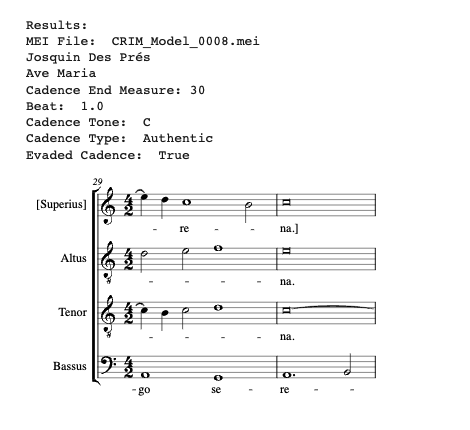

## A. Import Intervals and Other Code

* The first step is to import all the code required for the Notebook
* **`arrow/run`** or **`Shift + Enter`** in the following cell:

In [1]:
import intervals
from intervals import * 
from intervals import main_objs
import intervals.visualizations as viz
import pandas as pd
import re
import altair as alt 
from ipywidgets import interact
from pandas.io.json import json_normalize
from pyvis.network import Network

import os

from IPython.display import SVG


MYDIR = ("saved_csv")
CHECK_FOLDER = os.path.isdir(MYDIR)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR)
    print("created folder : ", MYDIR)

else:
    print(MYDIR, "folder already exists.")
    
MUSDIR = ("Music_Files")
CHECK_FOLDER = os.path.isdir(MUSDIR)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MUSDIR)
    print("created folder : ", MUSDIR)

else:
    print(MUSDIR, "folder already exists.")

saved_csv folder already exists.
Music_Files folder already exists.


## B. Importing a Piece

### B.1 Import a Piece and Check Title

In [2]:
# Select a prefix:

# prefix = 'Music_Files/'

# prefix = 'https://raw.githubusercontent.com/RichardFreedman/CRIM_Additions/main/'

prefix = 'https://crimproject.org/mei/'
# just add the CRIM Piece ID here
mei_file = 'CRIM_Model_0030.mei'
url = prefix + mei_file

piece = importScore(url)


print(piece.metadata)



Successfully imported https://crimproject.org/mei/CRIM_Model_0030.mei
{'title': 'Tant que vivray', 'composer': 'Claudin de Sermisy'}


## C. Find Cadences with Modular Analysis

Alex Morgan has built a powerful tool that identifies cadences according to the combinations of two-voice **modules** that describe the typical contrapuntal motion between the various **cadential voice functions** (**CVF**) heard in Renaissance polyphony:  **cantizans and tenorizans**, **cantizans and bassiszans**, etc.

The tool uses modular analysis to identify **conjunctions** of these pairs in order to predict cadences of various kinds. But there are many combinations, especially once we consider that voices functions (or roles) can be **displaced** (as when the tenorizans role appears in the Superius part and the cantizans appears in the Tenor part), or through **irregular** motion, and even **interrupted**, as when a voice is suddenly silent. 

You can in fact check all of the cadential voice functions (CVFs) for a given piece below.  But Alex's system also conveniently **labels** the cadences according to **type**, **tone**, **evaded** and also provides information about the relative place within the piece, the adjacent cadences, and many other features, too.

Note:  **Measure** and **Beat** columns are in the body of the table, not at the Index.

**Column Headings Explained**:

* The **Key** column is the string used by the classifier to determine the label. "BC1" for instance, means "bassus, cantus, and one leading tone".  Note that these letters appear in alphabetical order, not the order of the voices in the score.
* The **CadType** is a high-level label.  **Clausula Vera** is for cadences involving only Cantizans and Tenorizans; **Authentic** is for Cantizans and Bassizans (and possibly the Tenorizans, too).  **Phrygian Clausula Vera** is like **Clausula Vera** but with the half-step motion in the downward-moving (Tenorizans) part.  **Phrygian** corresponds to **Authentic**, except that the Bassizans of course moves up a fifth or down a fourth, as is normally the case when the Tenorizans descends by half=step.  **Altizans Only** is in cases where the Cantizans is missing and the Altizans role moves to a fifth above the lowest voice.  See `print(piece.cvfs.__doc__)` for other labels.
* ** Leading Tones** is the count of leading tones motions
* **CVFs** are the **Cadential Voice Functions**, and are listed in order from top to bottom as they appear in the score.  See `print(piece.cvfs.__doc__)` for details.
* The **Low** and **Tone** columns give the pitches of the **lowest sounding pitch (in any voice) at the perfection**, and the **goal tone of the cantizans** (or altizans if there is no cantizans) respectively.

* **RelLow** is the lowest pitch of each cadence shown as an interval measured against the last pitch in the **Low** column. Likewise, **RelTone** is the cadential tone shown as an interval measured against the last pitch in the **Tone** column.

* The **SinceLast** and **ToNext** columns are the time in quarter notes since the last or to the next cadence.

* The **Progress** column is a relative indication of position in the piece.  **0** is the beginning of the piece; **1.0** is the end of the piece.
* **Sounding** is the number of voices heard at the end of the cadence.



Read more via the documentation: **`print(piece.cadences.__doc__)`**

View the **Cadential Voice Function** and **Cadence Label** tables here:  https://github.com/HCDigitalScholarship/intervals/tree/main/intervals/data/cadences/.  These can easily be updated with revised or new cadence types.

### C.1 Classify the Cadences

In [3]:
cadences = piece.cadences(keep_keys=True)
cadences

,Key,CadType,LeadingTones,CVFs,Low,RelLow,Tone,RelTone,TSig,Measure,Beat,Sounding,Progress,SinceLast,ToNext
24.0,BC1,Authentic,1,CuTB,C3,-P4,C,P5,4/2,4,1.0,4,0.090909,24.0,64.0
88.0,BC1,Authentic,1,CTB,F3,P1,F,P8,4/2,12,1.0,4,0.333333,64.0,32.0
120.0,BC1,Authentic,1,CuTB,C3,-P4,C,P5,4/2,16,1.0,4,0.454545,32.0,64.0
184.0,BC1,Authentic,1,CTB,F3,P1,F,P8,4/2,24,1.0,4,0.696970,64.0,80.0
264.0,BC1,Authentic,1,CTB,F3,P1,F,P8,4/2,34,1.0,4,1.000000,80.0,16.0


In [4]:
# Reorganize the Columns:
col_list = ['Measure', 'Beat', 'CadType', 'Tone','LeadingTones', 'CVFs', 'Key','Low','RelLow','RelTone', 'Sounding', 'Progress','SinceLast','ToNext']
cadences = cadences[col_list]
cadences

,Measure,Beat,CadType,Tone,LeadingTones,CVFs,Key,Low,RelLow,RelTone,Sounding,Progress,SinceLast,ToNext
24.0,4,1.0,Authentic,C,1,CuTB,BC1,C3,-P4,P5,4,0.090909,24.0,64.0
88.0,12,1.0,Authentic,F,1,CTB,BC1,F3,P1,P8,4,0.333333,64.0,32.0
120.0,16,1.0,Authentic,C,1,CuTB,BC1,C3,-P4,P5,4,0.454545,32.0,64.0
184.0,24,1.0,Authentic,F,1,CTB,BC1,F3,P1,P8,4,0.696970,64.0,80.0
264.0,34,1.0,Authentic,F,1,CTB,BC1,F3,P1,P8,4,1.000000,80.0,16.0


In [5]:
cadences['CadType'].value_counts().to_frame()

,CadType
Authentic,5


### C.2  Check Voice Functions for all Cadences of a Given Piece

**`piece.cvfs()`** will return a table
of the **cadential voice functions** (CVFs). Each CVF is
represented with a single-character label with the meanings as follows.  
- Use `print(piece.cvfs.__doc__)` to view the explanation of the various 
labels.
- View the **Cadential Voice Function** and **Cadence Label** tables here: https://github.com/HCDigitalScholarship/intervals/tree/main/intervals/data/cadences/. These can easily be updated with revised or new cadence types.

In [6]:
print(piece.cvfs.__doc__)


        Return a dataframe of cadential voice functions in the piece. If
        `keep_keys` is set to True, the ngrams that triggered each CVF pair
        will be shown in additional columns in the table.

        Each CVF is represented with a single-character label as follows:

        Realized Cadential Voice Functions:
        "C": cantizans motion up a step (can also be ornamented e.g. Landini)
        "T": tenorizans motion down a step (can be ornamented with anticipations)
        "B": bassizans motion up a fourth or down a fifth
        "A": altizans motion, similar to cantizans, but cadences to a fifth
            above a tenorizans instead of an octave
        "L": leaping contratenor motion up an octave at the perfection
        "P": plagal bassizans motion up a fifth or down a fourth
        "Q": quintizans, like a tenorizans, but resolves down by fifth or up by
            fourth to a fourth below the goal tone of a cantizans or an octave
            below the goal tone

In [7]:
# To see a table with only the voice functions

cvf_list = piece.cvfs()
piece.detailIndex(cvf_list, offset=True).fillna('-')


,,,Superius,Contratenor,Tenor,Bassus
Measure,Beat,Offset,,,,
4,1.0,24.0,C,u,T,B
12,1.0,88.0,C,-,T,B
16,1.0,120.0,C,u,T,B
24,1.0,184.0,C,-,T,B
34,1.0,264.0,C,-,T,B


### C.3.  Check for Missed Cadences (One or More Pieces)


* The resulting table lists the **Cadential Voice Functions** (CVF's) for each of the probable cadences that the Cadence Classifier was **unable to categorize** according to the **Cadential Voice Function** and **Cadence Label** tables here: https://github.com/HCDigitalScholarship/intervals/tree/main/intervals/data/cadences/. These can easily be updated with revised or new cadence types.

* See below for additional instructions.

In [8]:

corpus = CorpusBase(['https://crimproject.org/mei/CRIM_Model_0008.mei']) # add as many pieces as you want here, each in single quotations, separated by commas
cad_dfs = corpus.batch(ImportedPiece.cadences, metadata=False)
cvf_dfs = corpus.batch(ImportedPiece.cadences)
missed = []
for i, cad in enumerate(cad_dfs):
    df = cvf_dfs[i].loc[cad.CadType.isnull(), :]
    df = df[df.columns[range(-2, len(df.columns) -2)]]
    df.columns = range(len(df.columns))
    missed.append(df)
result = pd.concat(missed)
rm = piece.detailIndex(result, offset=True)
result_offset_list = rm.index.get_level_values('Offset')

result_offset_list


Successfully imported https://crimproject.org/mei/CRIM_Model_0008.mei


Float64Index([], dtype='float64', name='Offset')

### C.4.  Check the Harmonic Modules of Missing Cadences

* For a given piece (since this tool works for one composition at a time), you can check the **harmonic modules** (for example `7_Held, 6_-2, 8` for a cantizans-tenorizans pair) at any given point in your piece
    * **Import the piece** (just ONE at a time)
    * Run the **"missed cadence finder"** (Section D) above.  You must run this with just ONE piece!
* The default **modular ngram** is 3 events long.  Adjust **`n`** as needed for longer modules
* The default **interval type** is diatonic ('d').  Adjust **`kind`** as needed for chromatic ('c')

Use the results to report the new cadential voice functions and label, as explained above.

In [9]:

ngs = piece.ngrams(n=3)
ngs_filtered = ngs.reindex(index = result_offset_list)
ngs_filtered.dropna(how='all').fillna('-')



,Bassus_Tenor,Bassus_Contratenor,Bassus_Superius,Tenor_Contratenor,Tenor_Superius,Contratenor_Superius
Offset,,,,,,


### C.4.  Display Results with Verovio

`verovio_print_cadences(piece, cadences, url, mei_file)`

Results:
MEI File:  CRIM_Model_0030.mei
Claudin de Sermisy
Tant que vivray
Cadence End Measure: 4
Beat:  1.0
Cadence Tone:  C
Cadence Type:  Authentic
Cadential Voice Functions:  CuTB


[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'


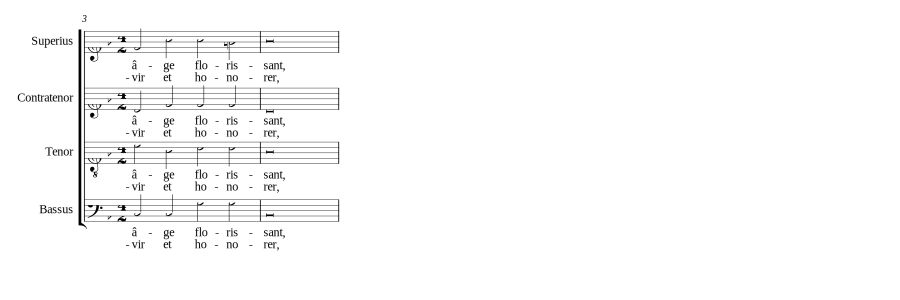

Results:
MEI File:  CRIM_Model_0030.mei
Claudin de Sermisy
Tant que vivray
Cadence End Measure: 12
Beat:  1.0
Cadence Tone:  F
Cadence Type:  Authentic
Cadential Voice Functions:  CTB


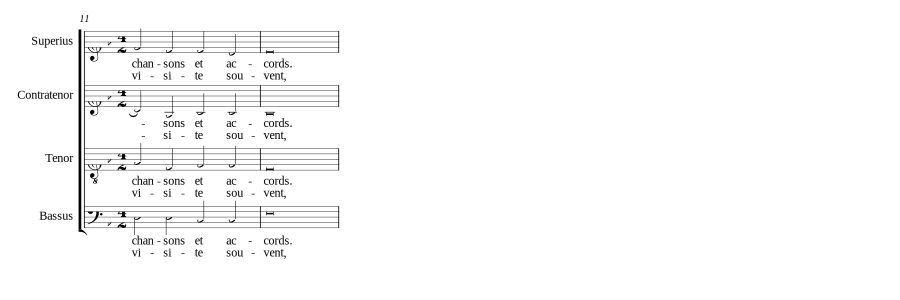

Results:
MEI File:  CRIM_Model_0030.mei
Claudin de Sermisy
Tant que vivray
Cadence End Measure: 16
Beat:  1.0
Cadence Tone:  C
Cadence Type:  Authentic
Cadential Voice Functions:  CuTB


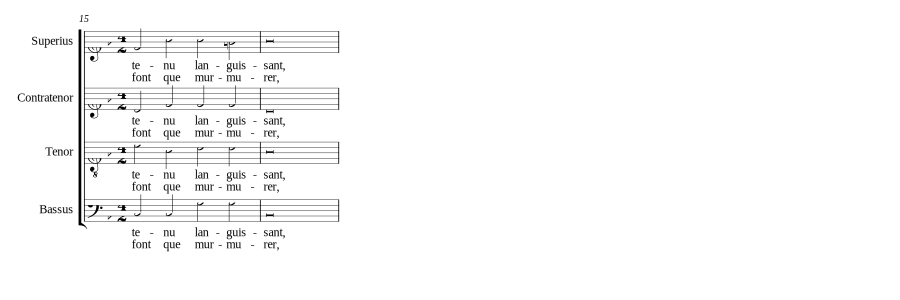

Results:
MEI File:  CRIM_Model_0030.mei
Claudin de Sermisy
Tant que vivray
Cadence End Measure: 24
Beat:  1.0
Cadence Tone:  F
Cadence Type:  Authentic
Cadential Voice Functions:  CTB


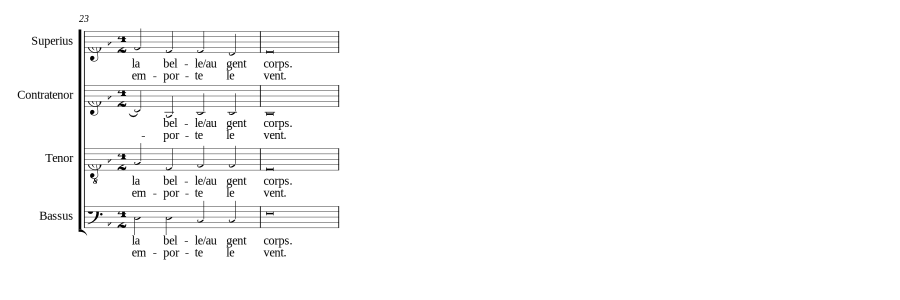

Results:
MEI File:  CRIM_Model_0030.mei
Claudin de Sermisy
Tant que vivray
Cadence End Measure: 34
Beat:  1.0
Cadence Tone:  F
Cadence Type:  Authentic
Cadential Voice Functions:  CTB


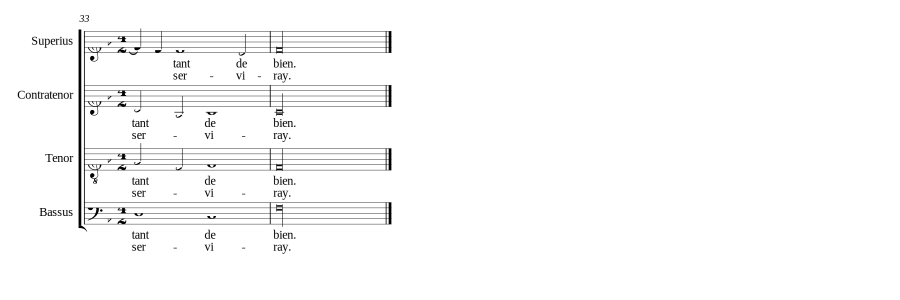

In [10]:
verovio_print_cadences(piece, cadences, url, mei_file)